In [1]:
!pip install easyocr
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 2.9/2.9 MB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 35.0/35.0 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 8.7 MB/s eta 0:00:00
     -------------------------------------- 172.4/172.4 MB 7.5 MB/s eta 0:00:00
     -------------------------------------- 313.0/313.0 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 95.1/95.1 kB 5.7 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25847 sha256=64c5a590415fb31d72336e9d5de7bb351b50e9a9f7137aa8260ab50f3ce5074c
  Stored in directory: c:\users\yashl\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

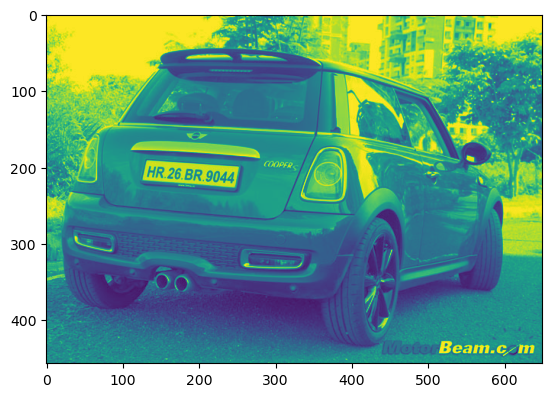

In [28]:
img = cv2.imread(r'C:\Users\yashl\Development\ANPRwithPython-main\ANPRwithPython-main\image1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray);

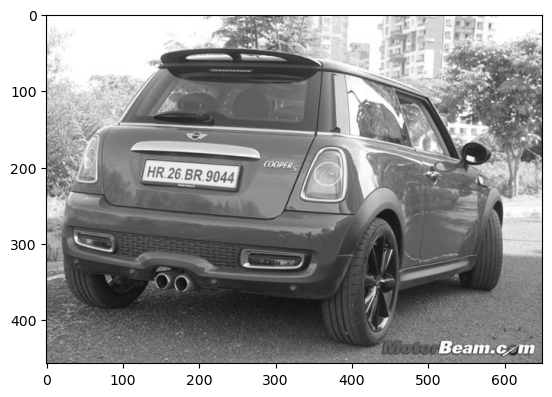

In [29]:
img = cv2.imread(r'C:\Users\yashl\Development\ANPRwithPython-main\ANPRwithPython-main\image1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB));

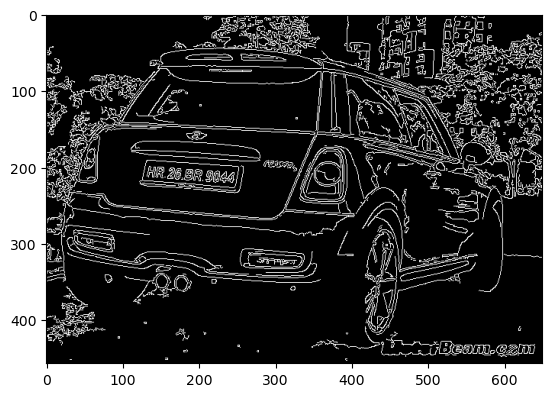

In [30]:
# Apply Filter and Find the edges for localization: 
# Filtering helps in removing noise from image and edge detection helps in clearly detecting edges of 
# specified objects in images.

bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # noise reduction
# 11, 17, 17 are the RGB values for how much intense we want our Noise reduction

edged = cv2.Canny(bfilter, 30, 200) # edge detection
# Canny is algorithm detect edges in our image

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB));

In [31]:
# Find Contours and Apply mask: 
# Contours: When we join all the points on the boundary of an object, we get a contour. 
# Typically, a specific contour refers to boundary pixels that have the same color and intensity. 

# Contour Detection is basically finding out where these lines are in an X-Y plane and convert it into polygons.
# ideally we will be seeing a rectangle as it is the shape our number plate.

keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
# ideally we will be able to see 
# 4 points denoting the shape of our number plate

contours = imutils.grab_contours(keypoints)
# extracts our contours

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
# showing top 10 contours in our image.

# next step is to loop through the contours and find out whether we got a 4 keypoint contour which represents our number plate

In [32]:
location = None # location of our 4 point contour

for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True) # 10 is the number to denote the accuracy of our contour to represent a rect.
    if len(approx) == 4:
        location = approx
        break

In [33]:
location

array([[[122, 219]],

       [[246, 227]],

       [[252, 200]],

       [[132, 191]]], dtype=int32)

In [34]:
# now we apply masking to section out the 4 points shown above:

mask = np.zeros(gray.shape, np.uint8) # everything black except our contour

new_image = cv2.drawContours(mask, [location], 0, 255, -1)

new_image = cv2.bitwise_and(img, img, mask=mask)  # return segment of img which we require

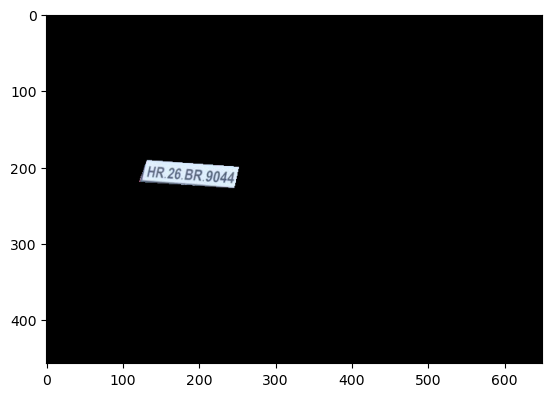

In [35]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB));

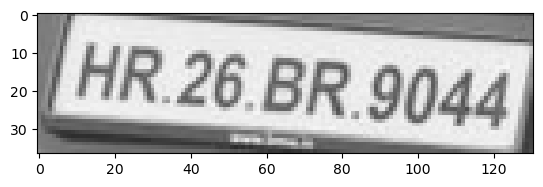

In [36]:
# isolate the image and delete the black part:
(x, y) = np.where(mask==255)

# Storing coords of 4 point contour
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

# adding a little buffer to image
cropped_image = gray[x1:x2+1, y1:y2+1]

# visualising image
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB));

In [37]:
# here we use EASYOCR for Character Recognition
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[6, 4], [128, 4], [128, 34], [6, 34]], 'HR.26 BR.9044', 0.5728024698084409)]

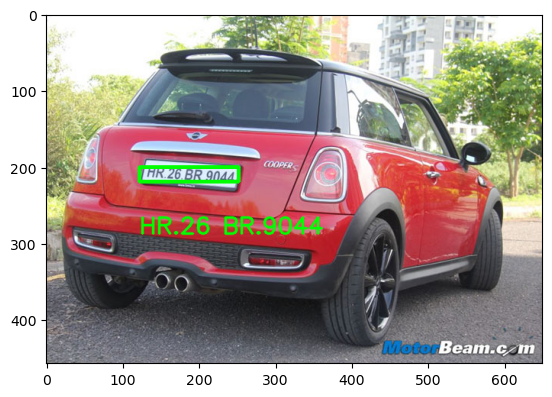

In [38]:
# analysing results:

text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text = text, 
                 org = (approx[0][0][0], approx[1][0][1] + 60),
                 fontFace = font,
                 fontScale = 1,
                 color = (0,255,0),
                 thickness = 2,
                 lineType = cv2.LINE_AA)

res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0), 3)

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB));